In [1608]:
# pip install pandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
from matplotlib.colors import Normalize


In [1609]:
dir_path = '../analysis/custom'
run_name = 'post-fumble-post-incaglr-post'

In [1610]:
# Load the data
item_log_df = pd.read_csv(f'{dir_path}/{run_name}/item_log.csv')
turtlebot_data_df = pd.read_csv(f'{dir_path}/{run_name}/turtlebot_data.csv')
item_data_df = pd.read_csv(f'{dir_path}/{run_name}/item_data.csv')
location_data_df = pd.read_csv(f'{dir_path}/{run_name}/location_data.csv')

In [1611]:
init_positions = {
    'robot1': {'x': -3.5, 'y': 2.0},
    'robot2': {'x': -3.5, 'y': 0.0},
    'robot3': {'x': -3.5, 'y': -2.0},
}

In [1612]:
turtlebot_grouped = turtlebot_data_df.groupby('Robot ID')
item_grouped = item_data_df.groupby('Robot ID')
location_grouped = location_data_df.groupby('Robot ID')

In [1613]:
location_data_df["Time"] = pd.to_numeric(location_data_df["Time"], errors='coerce')
location_data_df["X"] = pd.to_numeric(location_data_df["X"], errors='coerce')
location_data_df["Y"] = pd.to_numeric(location_data_df["Y"], errors='coerce')

In [1614]:
robot_names = {'robot1': 'Robot 1', 'robot2': 'Robot 2', 'robot3': 'Robot 3'}

In [1615]:
# Setting the threshold for identifying potential collisions
collision_threshold = -0.75
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
robot_colors = {robot: color for robot, color in zip(turtlebot_grouped.groups.keys(), colors)}

In [1616]:
# Processing for cumulative item value and distance traveled
item_value_data = item_log_df[['timestamp', 'total_value']]
color_contribution_data = item_log_df[['timestamp', 'red_value', 'green_value', 'blue_value']]
color_contribution_data['green_value'] += color_contribution_data['red_value']
color_contribution_data['blue_value'] += color_contribution_data['green_value']
# baseline_merged_data = turtlebot_data_df.groupby('Time').agg({'Distance Traveled':'sum'})
item_value_changes = item_value_data[item_value_data['total_value'].diff() > 0]
potential_collisions = turtlebot_data_df[turtlebot_data_df['Linear Acceleration'] < collision_threshold].groupby('Time').agg({'Distance Traveled': 'first'})

/tmp/ipykernel_122335/2217984318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  color_contribution_data['green_value'] += color_contribution_data['red_value']
/tmp/ipykernel_122335/2217984318.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  color_contribution_data['blue_value'] += color_contribution_data['green_value']


In [1617]:
# Function to determine the color based on the increase
def determine_color(row, prev_row):
    if row['red_count'] > prev_row['red_count']:
        return 'red'
    elif row['green_count'] > prev_row['green_count']:
        return 'green'
    elif row['blue_count'] > prev_row['blue_count']:
        return 'blue'
    else:
        return 'none'  # For no change or first row

# Applying the function to each row
item_value_changes['color'] = item_log_df.apply(lambda row: determine_color(row, item_log_df.loc[row.name - 1]) 
                                         if row.name > 0 else 'none', axis=1)

/tmp/ipykernel_122335/3232284223.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_value_changes['color'] = item_log_df.apply(lambda row: determine_color(row, item_log_df.loc[row.name - 1])


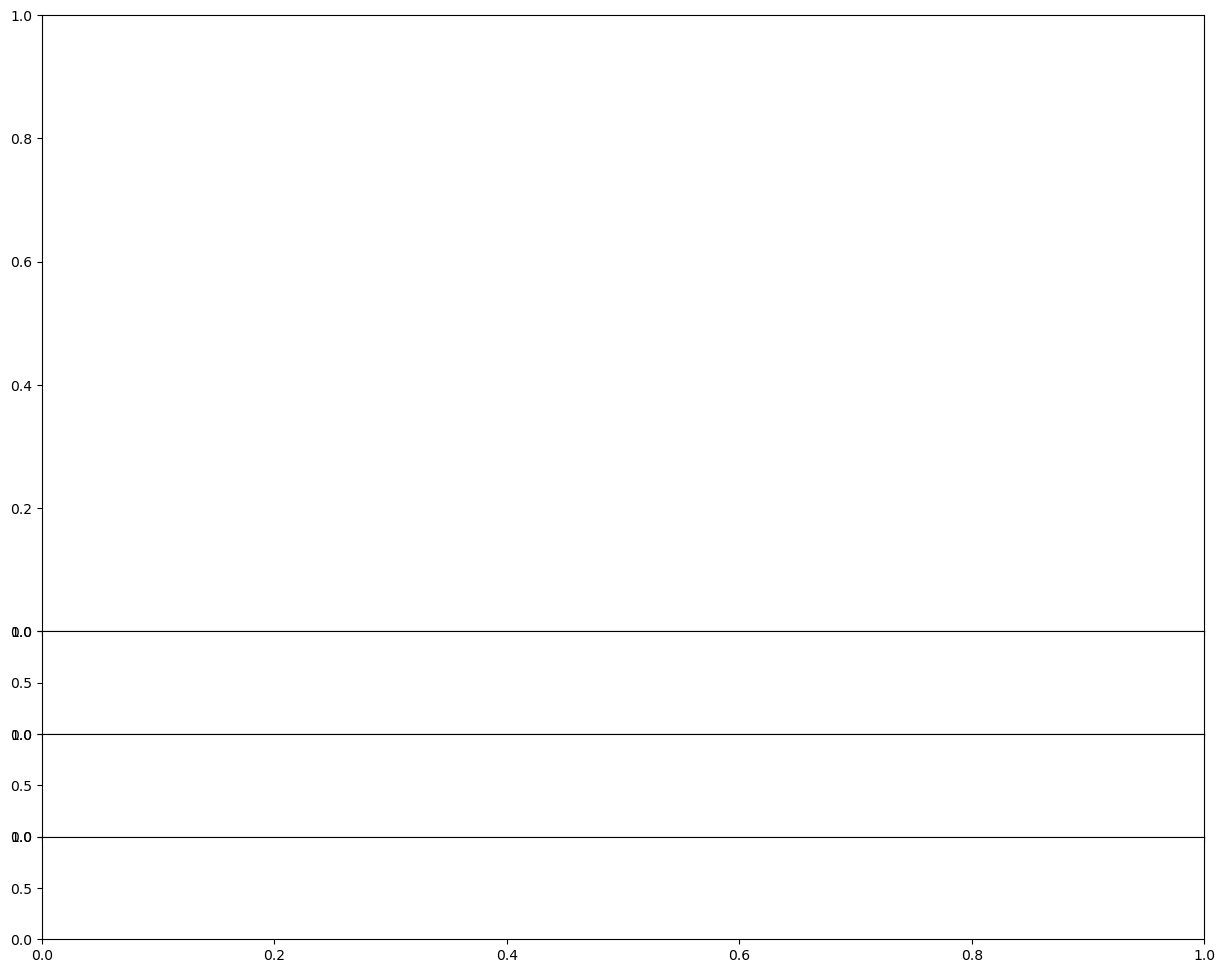

In [1618]:
# Create the plot
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(15, 12), gridspec_kw={'height_ratios': [1.5, .25, .25, .25]})
fig.subplots_adjust(hspace=0)

In [1619]:
# Top graph: Cumulative Item Value and Distance Traveled with Color Contributions
axs[0].plot(item_value_data['timestamp'].to_numpy(), item_value_data['total_value'].to_numpy(), label='Cumulative Item Value', color='tab:purple', linestyle='--')

axs[0].fill_between(color_contribution_data['timestamp'], 0, color_contribution_data['red_value'], color='red', alpha=0.3, label='Red Contribution')
axs[0].fill_between(color_contribution_data['timestamp'], color_contribution_data['red_value'], color_contribution_data['green_value'], color='green', alpha=0.3, label='Green Contribution')
axs[0].fill_between(color_contribution_data['timestamp'], color_contribution_data['green_value'], color_contribution_data['blue_value'], color='blue', alpha=0.3, label='Blue Contribution')

# axs[0].scatter(item_value_changes['timestamp'], item_value_changes['total_value'], color='black', label='Item Returned', marker='x')
axs[0].scatter(item_value_changes['timestamp'], 
            item_value_changes['total_value'], 
            color=item_value_changes['color'], 
            label='Item Returned', 
            marker='x')


axs[0].set_ylabel('Cumulative Item Value', color='tab:purple')
axs[0].tick_params(axis='y', labelcolor='tab:purple')

In [1620]:
# Right Y-axis: Distance Traveled
ax2 = axs[0].twinx()

potential_collisions = pd.DataFrame(columns=['Time', 'Distance Traveled'])

for robot_id, data in turtlebot_grouped:
    baseline_merged_data = data.groupby('Time').agg({'Distance Traveled':'sum'})
    
    temp_collisions = data[data['Linear Acceleration'] < collision_threshold].groupby('Time').agg({'Distance Traveled': 'first'})
    if not temp_collisions.empty:
        potential_collisions = pd.concat([potential_collisions, temp_collisions])
        
    ax2.plot(baseline_merged_data.index.to_numpy(), baseline_merged_data['Distance Traveled'].to_numpy(), label=f'Distance Traveled by {robot_names[robot_id]}', color=robot_colors[robot_id])


ax2.scatter(potential_collisions.index.to_numpy(), potential_collisions['Distance Traveled'].to_numpy(), color='red', label='Potential Collision', marker='^', zorder=5)


# ax2.plot(baseline_merged_data.index.to_numpy(), baseline_merged_data['Distance Traveled'].to_numpy(), label='Distance Traveled', color='tab:green')
ax2.set_ylabel('Distance Traveled (meters)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
 

In [1621]:
# Bottom graph: Item Value vs Timestamp

idx = 1
for robot_id, data in item_grouped:
    # Processing for item value vs timestamp
    pickup_times = data[data['Item Value'] != 0]
    dropoff_times = data[data['Item Value'] == 0]
    combined_item_events = pd.concat([pickup_times, dropoff_times]).sort_values(by='Time').reset_index(drop=True)
    
    for i in range(len(combined_item_events) - 1):
        axs[idx].plot(combined_item_events.iloc[i:i+2]['Time'].to_numpy(), combined_item_events.iloc[i:i+2]['Item Value'].to_numpy(), linestyle='--', color='gray', alpha=0.5)

    
    axs[idx].scatter(pickup_times['Time'], pickup_times['Item Value'], c=pickup_times['Item Colour'], label='Item Pickup', marker='o')
    axs[idx].scatter(dropoff_times['Time'], dropoff_times['Item Value'], color='black', label='Item Dropoff', marker='x')
    
    axs[idx].set_ylabel(f'{robot_names[robot_id]} \n Item Value', color='tab:blue')
    
    axs[idx].tick_params(axis='y', labelcolor='tab:blue')
    
    axs[idx].set_ylim(-1, max(combined_item_events['Item Value']) + 1)
    axs[idx].set_yticks(np.arange(0, max(combined_item_events['Item Value']) + 1, 2))

    axs[idx].yaxis.set_major_locator(plt.MultipleLocator(5))
    
    idx += 1

In [1622]:
x_ticks = np.arange(0, 20, 1)
x_ticks

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [1623]:
# Legends and titles
axs[0].legend(loc='upper left')
ax2.legend(loc='upper right')
axs[1].legend(loc='upper left')
axs[2].legend(loc='upper left')
axs[3].legend(loc='upper left')
axs[3].set_xlabel('Time (simulation minutes)')
plt.suptitle('Robot Performance, Cumulative Item Value with Color Contributions, and Item Collection Over Time')
plt.show()

<Figure size 640x480 with 0 Axes>

In [1624]:
axs[0].grid()
ax2.grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()

In [1625]:
axs[0].set_xticklabels(x_ticks)
ax2.set_xticklabels(x_ticks)
axs[1].set_xticklabels(x_ticks)
axs[2].set_xticklabels(x_ticks)
axs[3].set_xticklabels(x_ticks)


/tmp/ipykernel_122335/3199181857.py:1: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(x_ticks)
/tmp/ipykernel_122335/3199181857.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_ticks)
/tmp/ipykernel_122335/3199181857.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(x_ticks)
/tmp/ipykernel_122335/3199181857.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(x_ticks)
/tmp/ipykernel_122335/3199181857.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(x_ticks)


[Text(-500.0, 0, '0'),
 Text(0.0, 0, '1'),
 Text(500.0, 0, '2'),
 Text(1000.0, 0, '3'),
 Text(1500.0, 0, '4'),
 Text(2000.0, 0, '5'),
 Text(2500.0, 0, '6'),
 Text(3000.0, 0, '7'),
 Text(3500.0, 0, '8'),
 Text(4000.0, 0, '9'),
 Text(4500.0, 0, '10')]

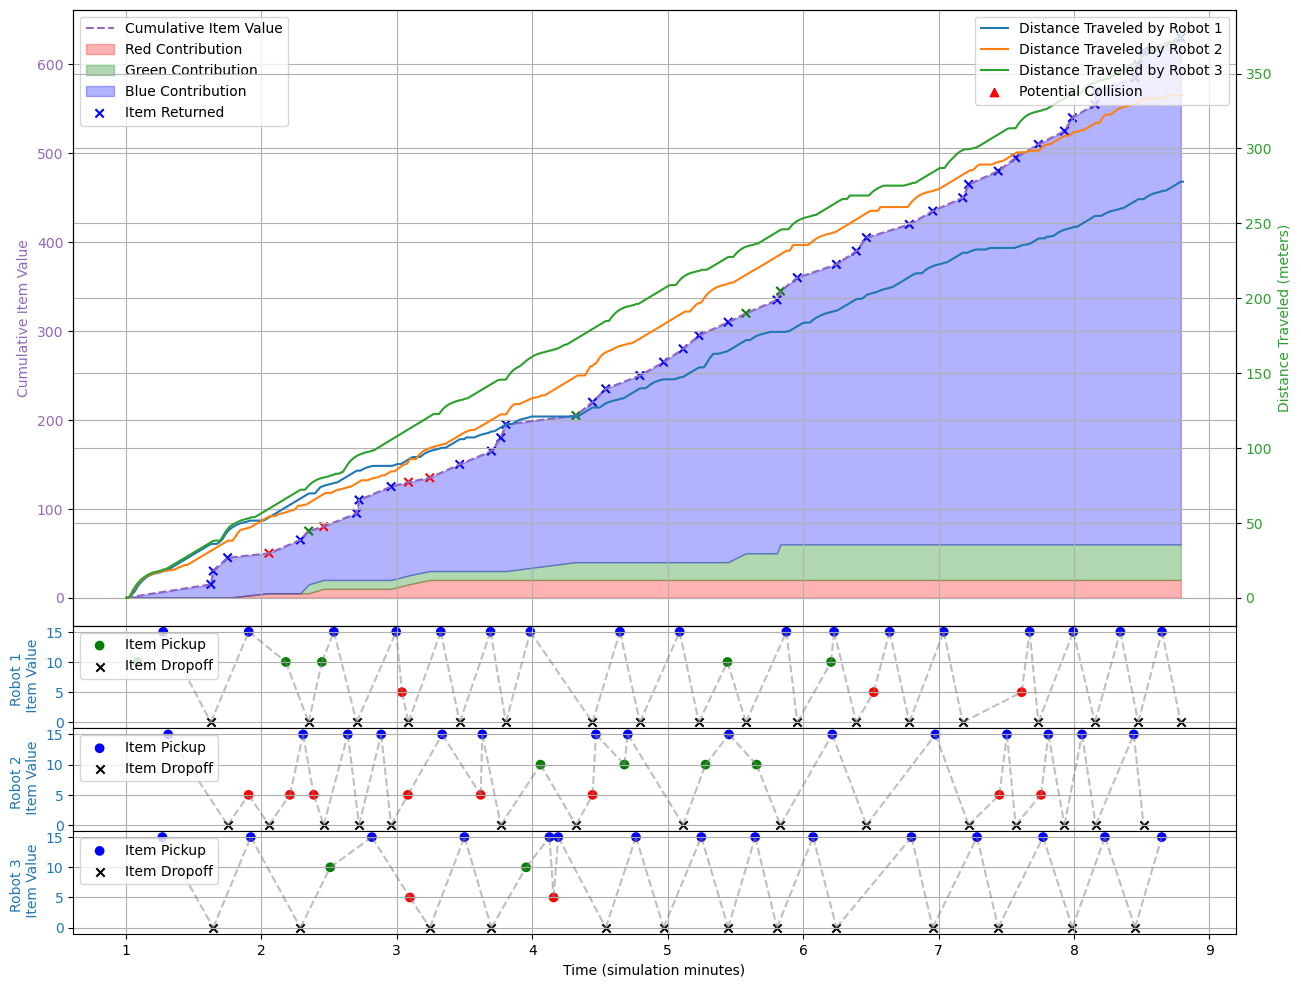

In [1626]:
fig

In [1627]:
location_data_df

,Time,Robot ID,Latitude,Longitude,Altitude,X,Y,Z,W
0,2.02,robot1,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000
1,2.02,robot2,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000
2,2.02,robot3,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000
3,4.02,robot1,-3.500000,2.000000,0.0,0.0,0.0,0.000000,2.000000
4,4.02,robot2,-3.500000,0.000000,0.0,0.0,0.0,0.000000,2.000000
...,...,...,...,...,...,...,...,...,...
5848,3900.02,robot2,-2.605001,0.205714,0.0,0.0,0.0,-0.070066,1.995704
5849,3900.02,robot3,-2.196230,-0.499999,0.0,0.0,0.0,0.733879,0.244224
5850,3902.02,robot1,-3.044890,2.077105,0.0,0.0,0.0,0.998565,1.268217
5851,3902.02,robot2,-2.604919,0.205699,0.0,0.0,0.0,-0.070179,1.995694


In [1628]:
# Convert appropriate columns to their correct data types
location_data_df["Time"] = pd.to_numeric(location_data_df["Time"], errors='coerce')
location_data_df["X"] = pd.to_numeric(location_data_df["X"], errors='coerce')
location_data_df["Y"] = pd.to_numeric(location_data_df["Y"], errors='coerce')

In [1629]:
location_data_df

,Time,Robot ID,Latitude,Longitude,Altitude,X,Y,Z,W
0,2.02,robot1,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000
1,2.02,robot2,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000
2,2.02,robot3,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000
3,4.02,robot1,-3.500000,2.000000,0.0,0.0,0.0,0.000000,2.000000
4,4.02,robot2,-3.500000,0.000000,0.0,0.0,0.0,0.000000,2.000000
...,...,...,...,...,...,...,...,...,...
5848,3900.02,robot2,-2.605001,0.205714,0.0,0.0,0.0,-0.070066,1.995704
5849,3900.02,robot3,-2.196230,-0.499999,0.0,0.0,0.0,0.733879,0.244224
5850,3902.02,robot1,-3.044890,2.077105,0.0,0.0,0.0,0.998565,1.268217
5851,3902.02,robot2,-2.604919,0.205699,0.0,0.0,0.0,-0.070179,1.995694


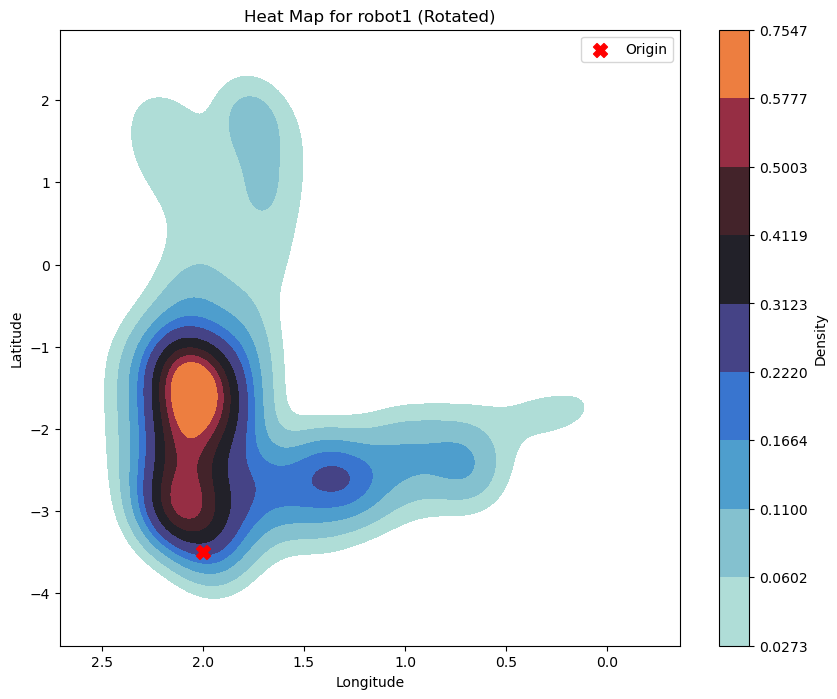

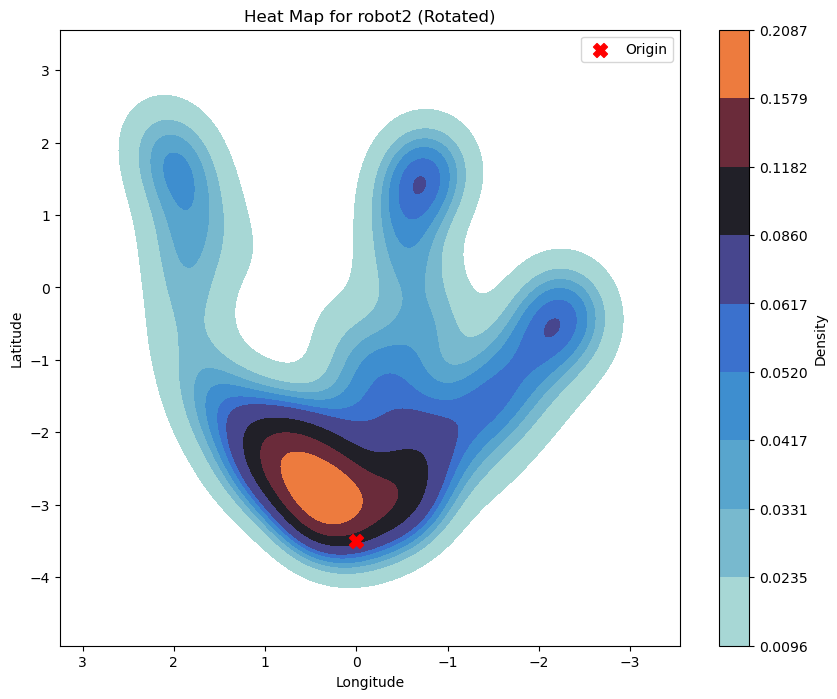

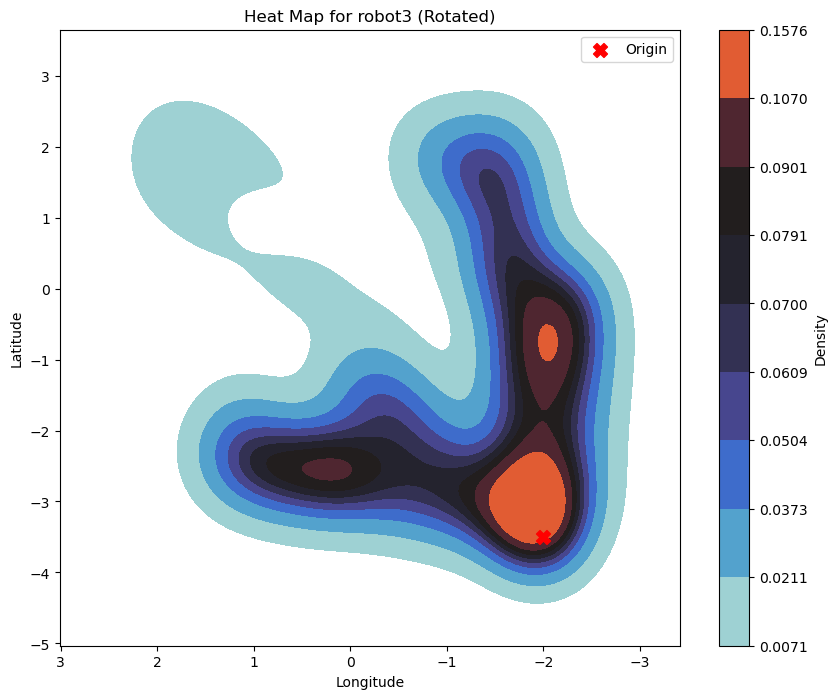

In [1630]:
zmap = sns.color_palette("icefire", as_cmap=True)
for robot_id, group in location_grouped:
    plt.figure(figsize=(10, 8))
    # Rotate the plot 90 degrees anti-clockwise by swapping X and Y
    ax = sns.kdeplot(data=group, x="Longitude", y="Latitude", cmap=zmap, fill=True, cbar=True, cbar_kws={'label': 'Density'})
    # Mark the origin point for each robot
    origin = init_positions[robot_id]
    plt.scatter(origin['y'], origin['x'], color='red', marker='X', s=100, label='Origin')
    plt.title(f"Heat Map for {robot_id} (Rotated)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.gca().invert_xaxis()
    plt.show()

In [1631]:
log_data = """
Spawning GREEN item0 at (-0.26, -1.94)
Spawning GREEN item1 at (0.16, -2.19)
Spawning GREEN item2 at (0.34, -1.86)
Spawning RED item3 at (-1.00, 0.01)
Spawning RED item4 at (-0.75, -0.16)
Spawning RED item5 at (-1.36, 0.06)
Spawning RED item6 at (-1.30, 0.38)
Spawning RED item7 at (-0.82, 0.38)
Spawning RED item8 at (-2.05, 1.11)
Spawning RED item9 at (-2.32, 1.37)
Spawning RED item10 at (-2.34, 1.03)
Spawning RED item11 at (-1.61, 0.78)
Spawning GREEN item12 at (-1.07, 2.47)
Spawning GREEN item13 at (-0.64, 2.01)
Spawning GREEN item14 at (-1.03, 2.05)
Spawning GREEN item15 at (-1.40, 2.00)
Spawning BLUE item16 at (1.98, -0.75)
Spawning BLUE item17 at (2.31, -1.38)
Spawning BLUE item18 at (1.99, -1.18)
Spawning BLUE item19 at (2.28, -0.91)
Spawning BLUE item20 at (1.95, 2.25)
Spawning BLUE item21 at (2.34, 1.99)
Spawning BLUE item22 at (2.31, 2.31)
Spawning BLUE item23 at (1.95, 1.92)
Spawning BLUE item20 at (-1.26, 1.59)
Spawning BLUE item17 at (1.67, -1.04)
Spawning BLUE item16 at (2.11, -0.58)
Spawning RED item3 at (-1.03, -0.37)
Spawning BLUE item18 at (1.91, -0.82)
Spawning GREEN item13 at (1.73, 1.74)
Spawning RED item8 at (-1.61, 1.27)
Spawning BLUE item23 at (-1.34, 2.12)
Spawning BLUE item20 at (-2.40, 1.00)
Spawning BLUE item20 at (-2.22, 1.06)
Spawning RED item9 at (-2.04, 0.97)
Spawning RED item3 at (-0.14, -1.65)
Spawning BLUE item23 at (-1.48, 2.02)
Spawning BLUE item20 at (-2.11, 1.32)
Spawning BLUE item21 at (-1.31, 0.05)
Spawning BLUE item23 at (-1.23, 2.13)
Spawning GREEN item1 at (0.13, -2.03)
Spawning BLUE item23 at (-1.00, 2.00)
Spawning BLUE item17 at (-0.40, -2.20)
Spawning BLUE item23 at (-1.06, 2.11)
Spawning BLUE item20 at (-2.27, 0.58)
Spawning BLUE item22 at (-0.98, 0.06)
Spawning BLUE item23 at (-0.94, 1.60)
Spawning BLUE item17 at (0.00, -2.31)
Spawning GREEN item12 at (-0.80, 2.00)
Spawning BLUE item21 at (-1.46, 0.11)
Spawning GREEN item12 at (-1.11, 2.12)
Spawning BLUE item20 at (-2.32, 0.76)
Spawning BLUE item22 at (-1.16, -0.05)
Spawning BLUE item18 at (-1.19, 2.38)
Spawning BLUE item17 at (0.00, -2.33)
Spawning BLUE item21 at (-2.23, 1.37)
Spawning BLUE item20 at (-2.02, 1.02)
Spawning BLUE item18 at (-0.88, 2.40)
Spawning BLUE item17 at (0.27, -2.37)
Spawning BLUE item21 at (-2.39, 0.73)
Spawning BLUE item20 at (-1.82, 1.27)
Spawning BLUE item21 at (-1.89, 0.93)
Spawning BLUE item20 at (-2.19, 1.15)
Spawning BLUE item17 at (0.09, -2.43)
Spawning BLUE item18 at (-1.33, 2.03)
Spawning BLUE item21 at (-2.01, 0.86)
Spawning BLUE item17 at (-0.19, -2.01)
Spawning BLUE item18 at (-1.21, 2.34)
Spawning BLUE item21 at (-1.92, 0.98)
Spawning BLUE item18 at (-0.73, 2.33)
"""

# Parsing the log data
log_lines = log_data.split('\n')
items = []

for line in log_lines:
    if line.startswith("Spawning"):
        parts = line.split(' ')
        color = parts[1]
        coords_part = line[line.find("(")+1:line.find(")")]
        if ',' in coords_part:
            coords = coords_part.split(',')
            try:
                x = float(coords[0])
                y = float(coords[1])
                value = {'BLUE': 15, 'GREEN': 10, 'RED': 5}.get(color, 0)
                items.append((x, y, value))
            except ValueError:
                print(f"Error parsing line: {line}")

df_items_corrected = pd.DataFrame(items, columns=['X', 'Y', 'Value'])


In [1632]:
# Define the colors for the custom cmap: red, green, blue
light_colors = [to_rgba('red', alpha=0.6), to_rgba('green', alpha=0.6), to_rgba('blue', alpha=0.6)]

n_bins = 100  # Increase this number for a smoother transition

# Create the colormap
cmap_name = 'custom_cmap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, light_colors, N=n_bins)


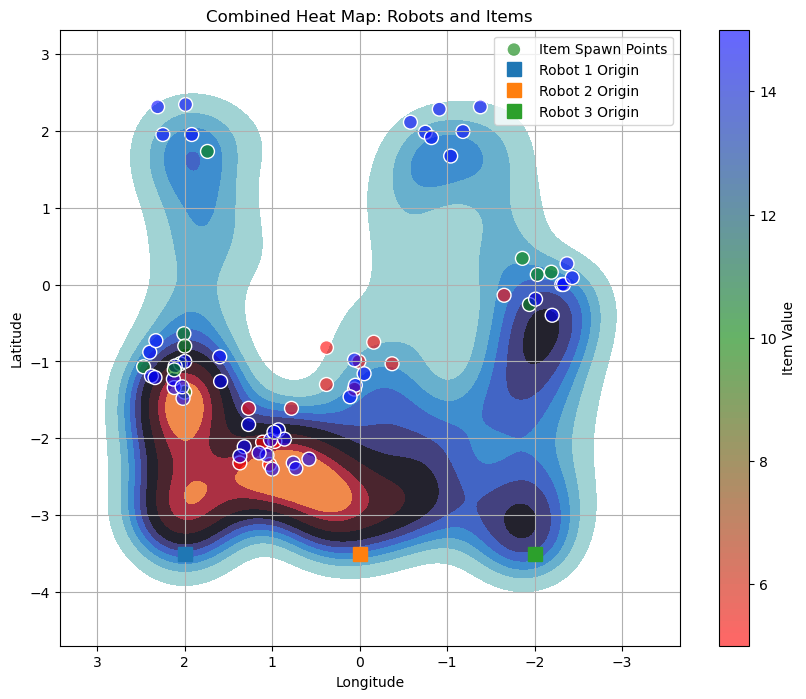

In [1633]:
plt.figure(figsize=(10, 8))
# Rotate the plot 90 degrees anti-clockwise by swapping X and Y
# sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
ax = sns.kdeplot(data=location_data_df, x="Longitude", y="Latitude", cmap=zmap, fill=True)

scatter_items = plt.scatter(df_items_corrected['Y'], df_items_corrected['X'], c=df_items_corrected['Value'], cmap=custom_cmap, s=100, edgecolor='w', marker='o', label='Item Spawn Points')

# Mark the origin point for each robot
for robot_id, pos in init_positions.items():
    plt.plot(pos['y'], pos['x'], marker='s', markersize=10, linestyle='None', label=f'{robot_names[robot_id]} Origin')

cbar = plt.colorbar(scatter_items)
cbar.set_label('Item Value')
               
# origin = init_positions[robot_id]
# plt.scatter(origin['y'], origin['x'], color='red', marker='X', s=100, label='Origin')
plt.title("Combined Heat Map: Robots and Items")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()

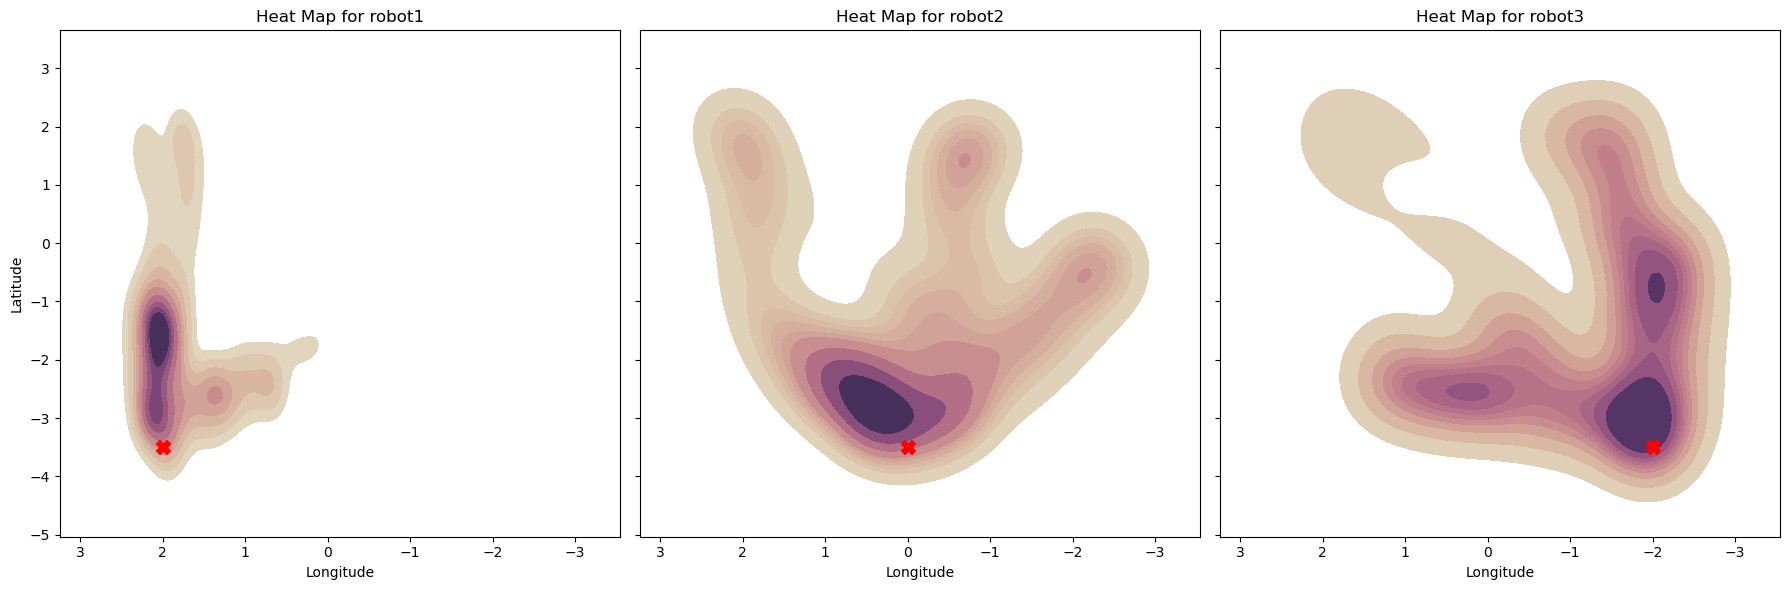

In [1634]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
# norm = Normalize(vmin=location_data_df['Longitude'].min(), vmax=location_data_df['Longitude'].max())

norm = Normalize(vmin=location_data_df['Longitude'].min(), vmax=location_data_df['Longitude'].max())




for ax, (robot_id, group) in zip(axs, location_grouped):
    sns.kdeplot(data=group, x="Longitude", y="Latitude", ax=ax, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True), fill=True)
    origin = init_positions[robot_id]
    ax.scatter(origin['y'], origin['x'], color='red', marker='X', s=100, label='Origin')
    ax.set_title(f'Heat Map for {robot_id}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

plt.gca().invert_xaxis()
plt.tight_layout()
# sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
# sm.set_array([])  # You can set an array of the same length as cmap to avoid a warning
# cbar = plt.colorbar(sm, ax=axs.ravel().tolist(), orientation='vertical')
cbar.set_label('Density')

plt.show()